In [236]:
from typing import List

import random

import dtw as dtw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from tqdm.notebook import tqdm


In [60]:
df_matches = pd.read_csv("../df_matching_scores.csv")
print("matches read: {}".format(df_matches.shape))
df_hourly = pd.read_csv("../m4_data/Hourly-train.csv")
print("hourly read: {}".format(df_hourly.shape))
df_daily = pd.read_csv("../m4_data/Daily-train.csv")
print("daily read: {}".format(df_daily.shape))
df_weekly = pd.read_csv("../m4_data/Weekly-train.csv")
print("weekly: {}".format(df_weekly.shape))
df_monthly = pd.read_csv("../m4_data/Monthly-train.csv")
print("monthly: {}".format(df_monthly.shape))
df_quarterly = pd.read_csv("../m4_data/Quarterly-train.csv")
print("quarterly: {}".format(df_quarterly.shape))
df_yearly = pd.read_csv("../m4_data/Yearly-train.csv")
print("yearly: {}".format(df_yearly.shape))

matches read: (1500000, 3)
hourly read: (414, 961)
daily read: (4227, 9920)
weekly: (359, 2598)
monthly: (48000, 2795)
quarterly: (24000, 867)


In [61]:
df_all = pd.concat([df_hourly,
                   df_daily,
                   df_weekly,
                    df_monthly,
                   df_quarterly,
                   df_yearly])

In [62]:
df_hourly = None
df_daily = None
df_weekly = None
df_monthly = None
df_quarterly = None
df_yearly = None

In [145]:
sample = random.choices(df_matches['ts_1'].unique(), k=10)

In [149]:
def compute_error_df(ts_names: List[str]) -> pd.DataFrame:
    ts_src_l = []
    ts_tgt_l = []
    mae_l = []
    rmse_l = []
    dtw_dist_l =  []
    for ts_src_name in tqdm(sample):
        df_tmp = df_matches[df_matches['ts_1']==ts_src_name]
        ts_src = np.array(df_all[df_all['V1']==ts_src_name].iloc[:,1:].dropna(axis=1))[0]
        ts_tgt_names = df_tmp['ts_2'].unique()

        for ts_tgt_name in ts_tgt_names:

            ts_tgt = np.array(df_all[df_all['V1']==ts_tgt_name].iloc[:,1:].dropna(axis=1))[0]
            # compute different lengths of series
            diff = ts_src.shape[0]-ts_tgt.shape[0]
            if diff>0:
                # src is longer than tgt
                ts_tgt = np.pad(ts_tgt, (0,diff))
            elif diff<0:
                # tgt is longer than src
                ts_src = np.pad(ts_src, (0,np.abs(diff)))
            else:
                # both series are equal in length
                pass
            n = np.maximum(len(ts_src), len(ts_tgt))
            mae = np.mean(np.abs(np.abs(ts_src)-np.abs(ts_tgt)))
            rmse = np.sqrt(np.mean(np.square(ts_src-ts_tgt)))
            aln = dtw.dtw(ts_src, ts_tgt, keep_internals=True)

            ts_src_l.append(ts_src_name)
            ts_tgt_l.append(ts_tgt_name)
            mae_l.append(mae)
            rmse_l.append(rmse)
            dtw_dist_l.append(aln.distance)

    data = {'ts_src': ts_src_l,
           'ts_tgt': ts_tgt_l,
           'mae': mae_l,
           'rmse': rmse_l,
            'dtw_dist': dtw_dist_l}
    return pd.DataFrame(data)
    

In [150]:
def generate_plots(df_err: pd.DataFrame) -> None:
    for ts_group in df_err.groupby('ts_src'):
        ts_src_name = ts_group[0]
        df_err_tmp = ts_group[1]
        df_err_tmp =  df_err_tmp.sort_values("mae").reset_index()
        ts_tgt_name = df_err_tmp.loc[0, 'ts_tgt']

        # getting data
        src_ar = np.array(df_all[df_all['V1']==ts_src_name].iloc[:,1:].dropna(axis=1))[0]
        tgt_ar = np.array(df_all[df_all['V1']==ts_tgt_name].iloc[:,1:].dropna(axis=1))[0]

        # aligning length of arrays
        diff = src_ar.shape[0] - tgt_ar.shape[0]
        if diff>0:
            # src is longer than tgt
            tgt_ar = np.pad(tgt_ar, (0, diff))
        elif diff<0:
            src_ar = np.pad(src_ar, (0, np.abs(diff)))
        else:
            pass

        # plotting
        n = np.maximum(len(src_ar), len(tgt_ar))
        x = np.array(range(n))
        plt.plot(x, src_ar, label=ts_src_name)
        plt.plot(x, tgt_ar, linestyle='--', label=ts_tgt_name)
        plt.legend()
        title = ts_src_name + " and " + ts_tgt_name
        plt.title(title)
        plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

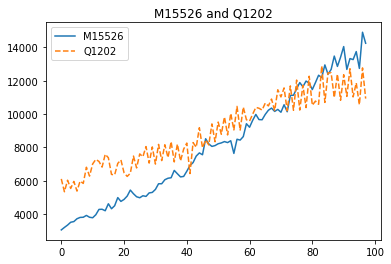

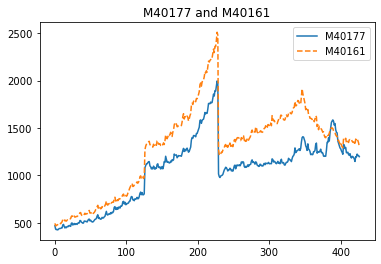

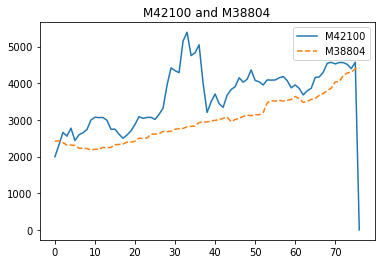

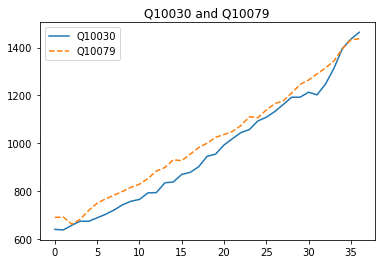

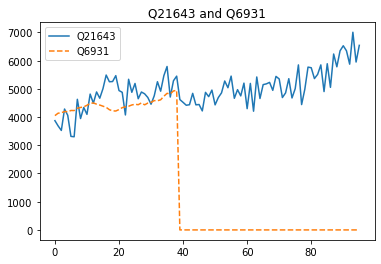

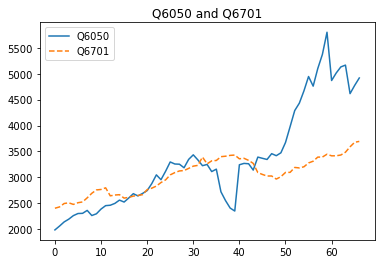

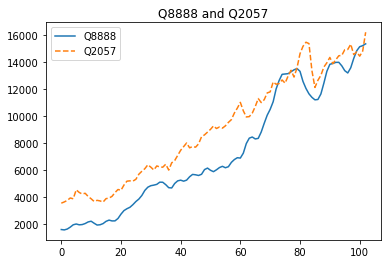

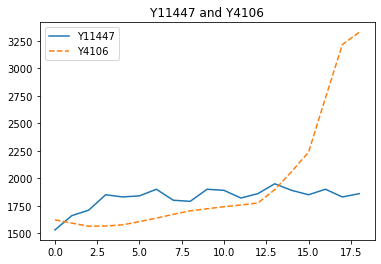

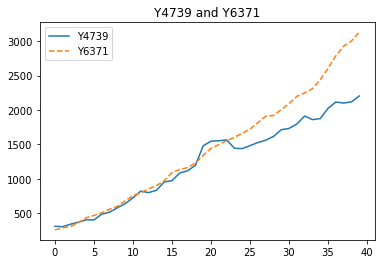

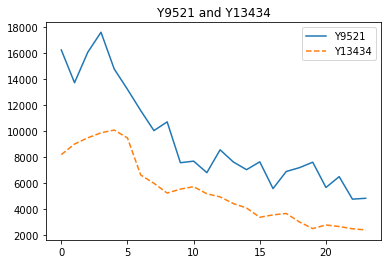

In [218]:
sample = random.choices(df_matches['ts_1'].unique(), k=10)

df_err = compute_error_df(sample)
generate_plots(df_err)

In [159]:
ar1=np.array(df_all[df_all['V1']=='D1219'].iloc[:,1:].dropna(axis=1))[0]
ar2=np.array(df_all[df_all['V1']=='D2514'].iloc[:,1:].dropna(axis=1))[0]

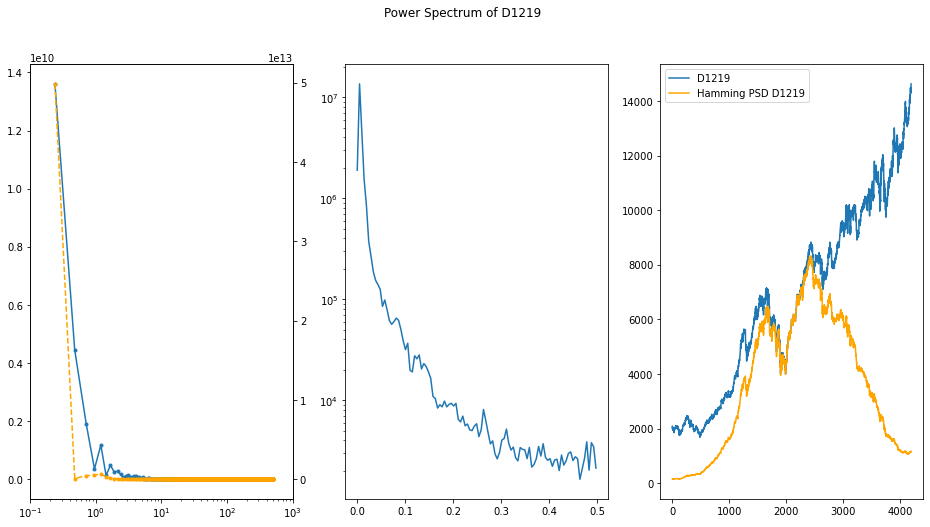

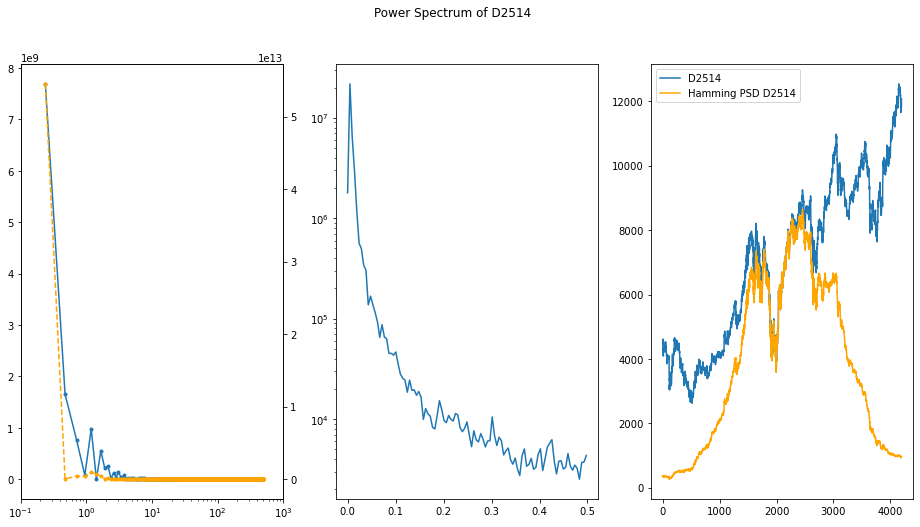

/Users/philipp/anaconda3/envs/unic2/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


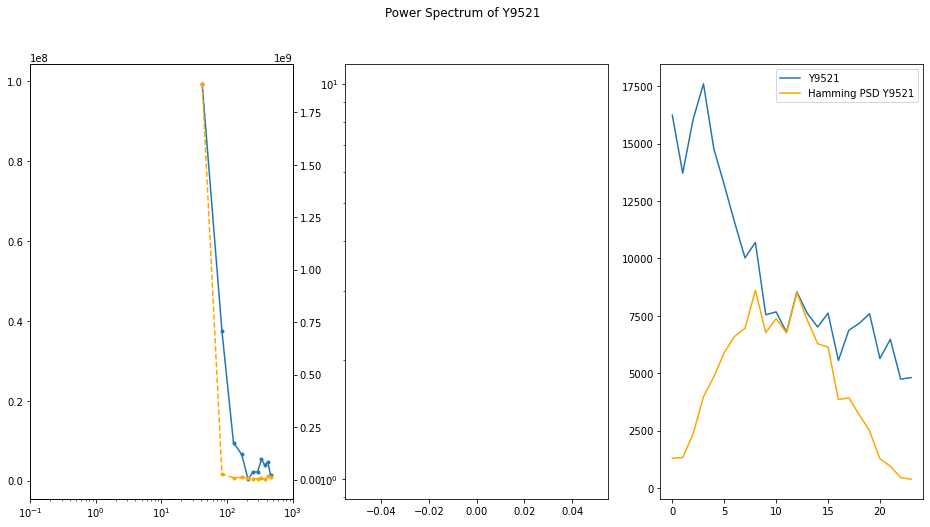

/Users/philipp/anaconda3/envs/unic2/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


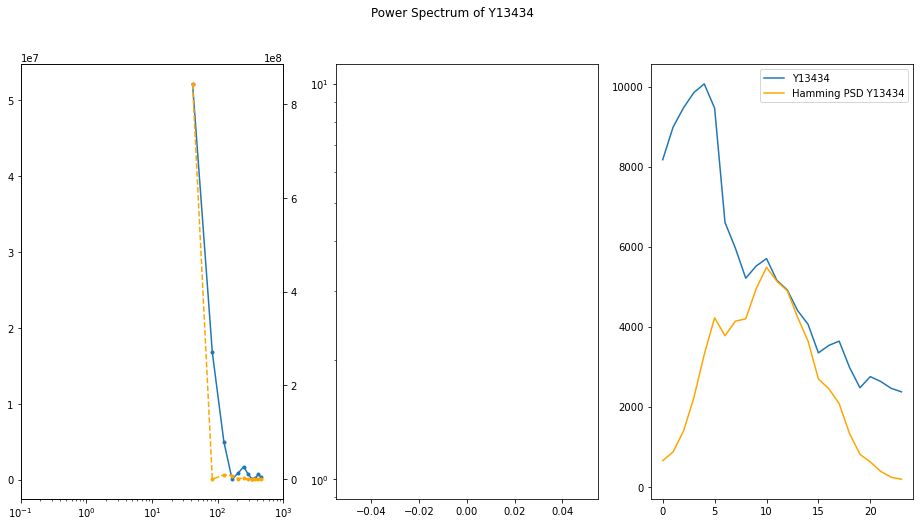

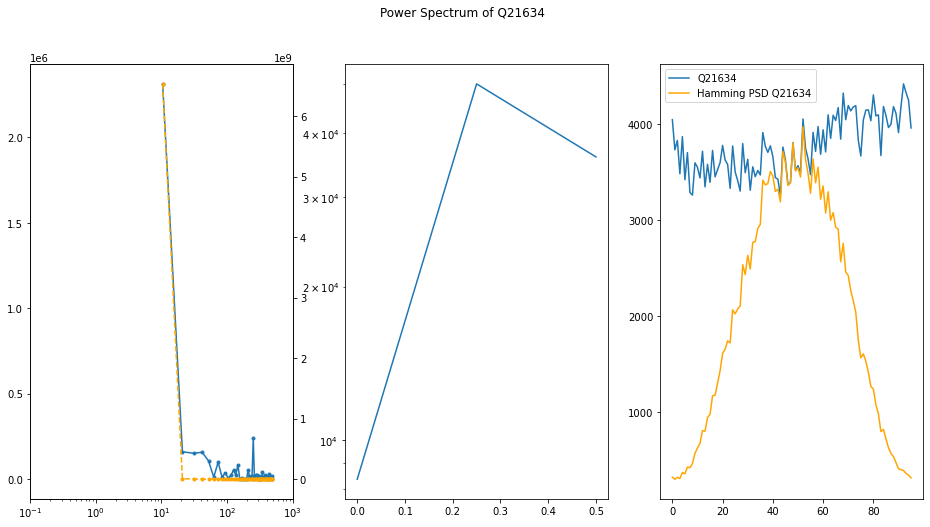

In [242]:
ts_names = ['D1219', 'D2514', 'Y9521', 'Y13434', 'Q21634']
for ts_name in ts_names:
    ar=np.array(df_all[df_all['V1']==ts_name].iloc[:,1:].dropna(axis=1))[0]
    n = ar.shape[0]
    ar_hamming = ar * np.hamming(n)
    dt = 0.001
    fhat = np.abs(np.fft.fft(ar)) # compute the FFT
    fhat_hamming = np.abs(np.fft.fft(ar_hamming))
    PSD = fhat * np.conj(fhat) / n # build power spectrum
    PSD_hamming = fhat_hamming * np.conj(fhat_hamming)
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1, np.floor(n/2), dtype='int')
    
    # Welch's method
    
    f, Pxx_den = signal.welch(ar, nperseg=np.floor(1/20*n), window='hamming')

    # plotting
    fig, axes = plt.subplots(1,3, figsize=(16,8))
    axes.flatten()[0].set_xscale('log')
    axes.flatten()[0].set_xlim(10**-1,10**3)
    twin1 =axes.flatten()[0].twinx()
#     twin2 =axes.flatten()[0].twinx()
    axes.flatten()[0].plot(freq[L], PSD[L], ".-", label=ts_name)
#     axes.flatten()[0].legend()
    label_hamming = "Hamming PSD " + ts_name
    twin1.plot(freq[L], PSD_hamming[L], ".--",
               color='orange', label=label_hamming)
    
#     twin1.plot(f, Pxx_den, "*-", color='r', label='Welch')
#     twin2.legend()
    axes.flatten()[1].semilogy(f, Pxx_den, label='Welch')


    axes.flatten()[2].plot(ar, label=ts_name)
    axes.flatten()[2].plot(ar_hamming, color='orange', label=label_hamming)
    axes.flatten()[2].legend()
    title = "Power Spectrum of " + ts_name
    fig.suptitle(title)
    plt.show()
    plt.close()
    

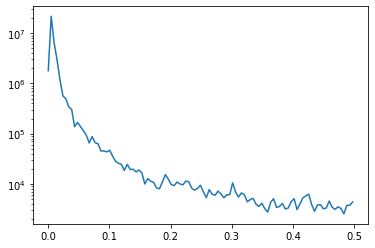

In [244]:
ar=np.array(df_all[df_all['V1']=='D2514'].iloc[:,1:].dropna(axis=1))[0]
n = ar.shape[0]
f, Pxx_den = signal.welch(ar, nperseg=np.floor(1/20*n), window='hamming')
plt.semilogy(f, Pxx_den)

In [260]:
ar.shape

(4197,)

In [253]:
np.argsort(Pxx_den)[-5:]

array([4, 0, 3, 2, 1])

In [259]:
Pxx_den.shape

(105,)

In [256]:
art = np.array([2,10,1,0,20])

np.argsort(art)[-2:]

array([1, 4])